In [1]:
from collections import defaultdict
from typing import Optional

import numpy as np
import pandas as pd
import seaborn as sns
from data_util import labeled_particles
from matplotlib import pyplot as plt
from numba import njit, prange
from tqdm import tqdm

sns.set_theme(style='darkgrid')

In [2]:
# code adapted  from napari.utils.colormaps.colormap


def get_dtype_py(num_colors: int):
    if num_colors < 255:
        return np.uint8
    if num_colors < 65536:
        return np.uint16
    return np.float32


get_dtype_nu = njit(get_dtype_py)


@njit(parallel=True)
def zero_preserving_modulo_numba(
    values: np.ndarray, n: int, to_zero: int = 0, out: Optional[np.ndarray] = None, dtype: np.dtype = np.uint8
) -> np.ndarray:
    out = np.empty_like(values, dtype=dtype)
    for i in prange(values.size):
        if values.flat[i] == to_zero:
            out.flat[i] = 0
        else:
            out.flat[i] = (values.flat[i] - 1) % n + 1

    return out


@njit()
def zero_preserving_modulo_numba_seq(
    values: np.ndarray, n: int, to_zero: int = 0, out: Optional[np.ndarray] = None, dtype: np.dtype = np.uint8
) -> np.ndarray:
    out = np.empty_like(values, dtype=dtype)
    for i in range(values.size):
        if values.flat[i] == to_zero:
            out.flat[i] = 0
        else:
            out.flat[i] = (values.flat[i] - 1) % n + 1

    return out


def zero_preserving_modulo_numpy(values: np.ndarray, n: int, dtype: np.dtype, to_zero: int = 0) -> np.ndarray:
    res = ((values - 1) % n + 1).astype(get_dtype_py(n + 1))
    res[values == to_zero] = 0
    return res

In [3]:
data_small_32 = np.arange(32 * 32, dtype=np.int32).reshape(32, 32)
data_small_64 = np.arange(32 * 32, dtype=np.int64).reshape(32, 32)
data_particles_2d_1024 = labeled_particles((1024, 1024), dtype=np.uint32)
data_particles_2d_2048 = labeled_particles((2048, 2048), n=500, dtype=np.uint32)
data_particles_3d_50_1024 = labeled_particles((50, 1024, 1024), dtype=np.uint32)
data_particles_3d_100_2048 = labeled_particles((100, 2048, 2048), dtype=np.uint32)
data_particles_3d_100_2048_54 = labeled_particles((100, 2048, 2048), dtype=np.uint64)

data_list = [
    (data_small_32, 'data_small_32'),
    (data_small_64, 'data_small_64'),
    (data_particles_2d_1024, 'data_particles_2d_1024'),
    (data_particles_2d_2048, 'data_particles_2d_2048'),
    (data_particles_3d_50_1024, 'data_particles_3d_50_1024'),
    (data_particles_3d_100_2048, 'data_particles_3d_100_2048'),
    (data_particles_3d_100_2048_54, 'data_particles_3d_100_2048_54'),
]

In [4]:
random_data = []
random_data3d = []
for msize in [2**x for x in range(6, 14)]:
    values = np.random.randint(100000, size=(msize, msize), dtype=np.int32)
    random_data.append((values, f'random_({msize},{msize})_{msize*msize}'))
    values = np.random.randint(100000, size=(30, msize, msize), dtype=np.int32)
    random_data3d.append((values, f'random_(30,{msize},{msize})_{msize*msize*30}'))

In [5]:
for _ in range(10):
    zero_preserving_modulo_numba(data_small_32, n=49, to_zero=0, dtype=np.uint8)
    zero_preserving_modulo_numba_seq(data_small_32, n=49, to_zero=0, dtype=np.uint8)
    zero_preserving_modulo_numba(data_small_64, n=49, to_zero=0, dtype=np.uint8)

In [6]:
def measure_data(data_li):
    res = defaultdict(list)
    for _data, _name in tqdm(data_li):
        r = %timeit -o -q zero_preserving_modulo_numba(data, n=49, to_zero=0, dtype=np.uint8)
        res['numba'].append(r)
        r = %timeit -o -q zero_preserving_modulo_numba_seq(data, n=49, to_zero=0, dtype=np.uint8)
        res['numba seq'].append(r)
        r = %timeit -o -q zero_preserving_modulo_numpy(data, n=49, to_zero=0, dtype=np.uint8)
        res['numpy'].append(r)
        r = %timeit -o -q zero_preserving_modulo_sequential(data, modulo_factor=49, to_zero=0)
        res['cython seq'].append(r)
        r = %timeit -o -q zero_preserving_modulo_parallel(data, modulo_factor=49, to_zero=0)
        res['cython par'].append(r)
    return res

In [7]:
predef_res = measure_data(data_list)

Profile modulo 49


100%|████| 7/7 [04:37<00:00, 39.66s/it]


In [8]:
random_res = measure_data(random_data)

Profile random data modulo 49


100%|████| 8/8 [04:18<00:00, 32.37s/it]


In [9]:
random_res3d = measure_data(random_data3d)

Profile random data modulo 49


100%|████| 8/8 [07:36<00:00, 57.10s/it]


In [10]:
def make_dataframe(dkt, data_li):
    df_data = []
    for name, values in dkt.items():
        for tr, (_data, data_name) in zip(values, data_li):
            for run in tr.timings:
                df_data.append([name, data_name, run])
    return pd.DataFrame(df_data, columns=['name', 'data name', 'run time'])

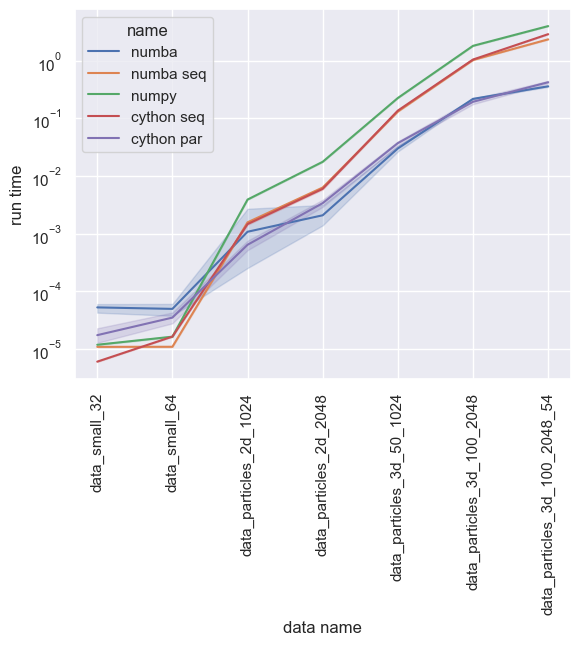

In [11]:
sns.lineplot(make_dataframe(predef_res, data_list), x='data name', y='run time', hue='name')
plt.xticks(*plt.xticks(), rotation='vertical')
plt.yscale('log')

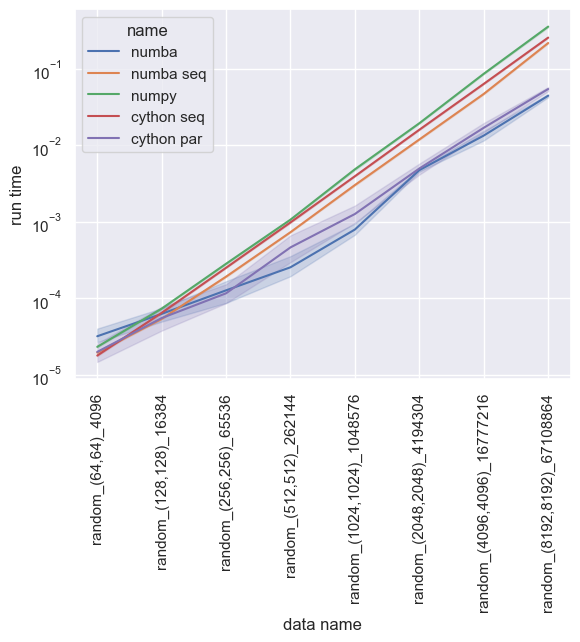

In [12]:
sns.lineplot(make_dataframe(random_res, random_data), x='data name', y='run time', hue='name')
plt.xticks(*plt.xticks(), rotation='vertical')
plt.yscale('log')

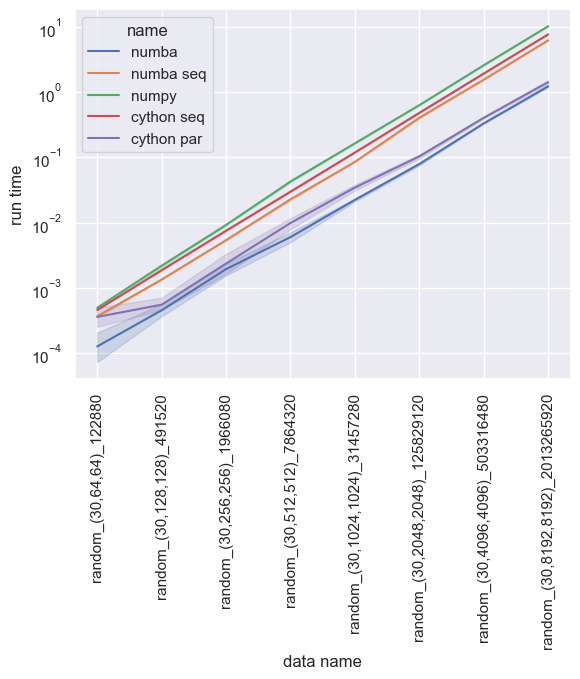

In [13]:
sns.lineplot(make_dataframe(random_res3d, random_data3d), x='data name', y='run time', hue='name')
plt.xticks(*plt.xticks(), rotation='vertical')
plt.yscale('log')

In [14]:
d = np.full((1,), 240)
%timeit zero_preserving_modulo_numba_seq(d, n=49, to_zero=0, dtype=np.uint8)
%timeit zero_preserving_modulo_numpy(d, n=49, to_zero=0, dtype=np.uint8)

7.79 µs ± 194 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
4.88 µs ± 151 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
